# Check_spinup global results
- reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS/OUTPUT_CN/SPIN

#### --- CRUNCEP runs  --- :
- `MIMICS_def`, as in GRL 2019 paper, but with additional CN parameters
- `MIMICS_desorb`, increased desorb 5x as in Zhang 2000 paper
- `MIMICS_desorb2` decreased desorb 10x from default, decreased fPHYS 5x from default
            FI: FI_phys = 0.005, 10x lower, FI_chem = 0.10, 2x higher;  
            KO = 9 (from 6) to increase SOMc stocks

#### --- GSWP3 runs  --- : 
- `MIMICS_desorb2_GSWP3` as above, but pointing to  GSPW3
- `MIMICS_mod3_GSWP3`, increase KO = 12, and double MIC turnover to increase SOC stocks and reduce MIC
- `MIMICS_mod3_borealNfix_GSWP3`, increase Nfix in boreal systems **maybe revert?**

#### --- increased MIMICS leaching & modifiend density dependend parameterizaiton ---
   **Switched to updated CLM5-GSWP3 inputs (created with ctsm_dev110 tag)**
- `MIMICS_mod4_GSWP3`,  leaching as fraction of total DIN pool
- `MIMICS_mod4_dens1.0_GSWP3`, density dependent exponent = 1
- **`MIMICS_mod4_dens1.0_KO6_GSWP3`**, KO = 6, turnover * desorbtion as in `MIMICS_desorb2`
  - This seems like the **best** run & most similar to previously published C-only simulations
- **`MIMICS_mod4_dens1.0_KO6_micCN_GSWP3`**, as above, but includes flexible microbial CN
  - These simulations had funny chages in NPP and TOTC, the later showing > 3 gC/m2/100 years in isotalated grid cells, even after 20k year spinup.
  - Also, MIMCScn has large and increasing CWDc pools in all cases, mainly in boreal forests
  - CASA logic for N limitation (xknlimiting) was still being used for CWD decay into LITs.
  - WRW removed this in the code and repeated MIMCScn simulations to test results.
- `MIMICS_mod4_dens1.0_KO6_Conly`, C-only of above
- `CASACNP_mod4_GSWP3`
- `CASACNP_mod4_Conly`

In [1]:
import xarray as xr
import xesmf as xe  # to regrid observations
import dask.array as da  # need to have dask.array installed, although not directly using it here.
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print(xr.__version__)
%matplotlib inline

0.16.1


In [2]:
import pandas.util.testing as tm
model = 'mim' #'mim'
CN = True 
path = '/project/tss/wwieder/biogeochem_testbed_1.1/'
sim  = 'MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3'#'CASACNP_mod4_GSWP3' 

if CN == True:
    case = 'GRID_CN/'+sim+'/OUTPUT_CN/SPIN2/'
else:
    case = 'GRID_CN/'+sim+'/OUTPUT_C/SPIN2/'

full_pathMIM = path+case+'mimics_pool_flux_*80.nc'  # read in data every 10 years
full_pathCAS = path+case+'casaclm_pool_flux_*80.nc' # casa files for vegetation results
print(full_pathCAS)

if model == 'mim':
    ds   = xr.open_mfdataset(full_pathMIM, decode_times=True, combine='by_coords')
    dsVeg= xr.open_mfdataset(full_pathCAS, decode_times=True, combine='by_coords')
    #combine relevent data from casa history files to MIMICS data
    vegVar = ['cnpp','cgpp','nMineral','tsoilC','thetaLiq','clitcwd']
    if CN == True:
        vegVar = vegVar+['nMinLoss','nMinLeach','nNetMineralization','nSoilImmob']
    for i in range(len(vegVar)):
        ds[vegVar[i]] = dsVeg[vegVar[i]]
    
if model == 'cas':
    ds = xr.open_mfdataset(full_pathCAS, decode_times=True, combine='by_coords')

# sum soil C & N pools
ds = utils.sum_pools(ds, model)

# mask out low productivity cells
minNPP = 10
ds = ds.where(ds['cnpp']>minNPP)
print('-- read in dataset -- ')

/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3/OUTPUT_CN/SPIN2/casaclm_pool_flux_*80.nc


/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """Entry point for launching an IPython kernel.


-- read in dataset -- 


## Define function for global sum & spatial plots

In [3]:
area = ds.landarea.isel(time=-1) *1e6
def globalSum ( dsIn, var, area=area, time=1, conversion=1e-15, units=None, plot=True ):
    "Global weighted sum of fluxes & states"
    temp = dsIn[var] * area 
    temp = temp.sum(dim=('lat','lon')) * conversion
    if plot==True:
        plt.figure(figsize=[25,6]);
        for i in range(len(var)):
            plt.subplot(1, len(var), (1+i))
            plt.ylabel('Global '+var[i]+' (Pg C y^-1)')
            plt.plot(temp['time'], temp[var[i]]);

    else:
        for i in range(len(var)):
            print('global '+var[i]+' '+str(np.round(temp[var[i]].isel(time=-1).values,1) )+' Pg C')

In [4]:
# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:  # here to right of plots
        fig.colorbar(im, ax=ax,shrink=0.40, pad=0, fraction = 0.1)

    # allows for different colorbars on each plot
    if cb == 2:  # here below plots
        fig.colorbar(im, ax=ax,shrink=0.9, pad=0, fraction = 1, orientation="horizontal")

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']  

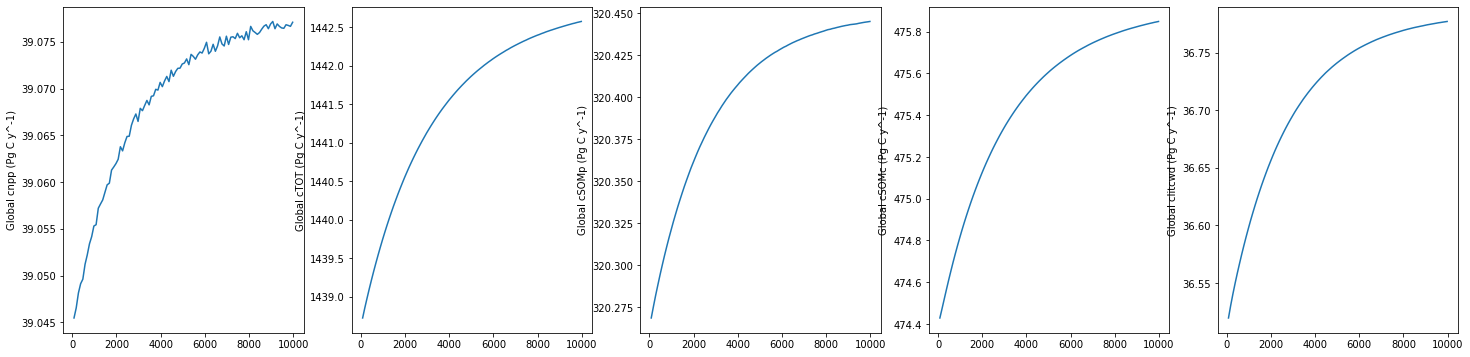

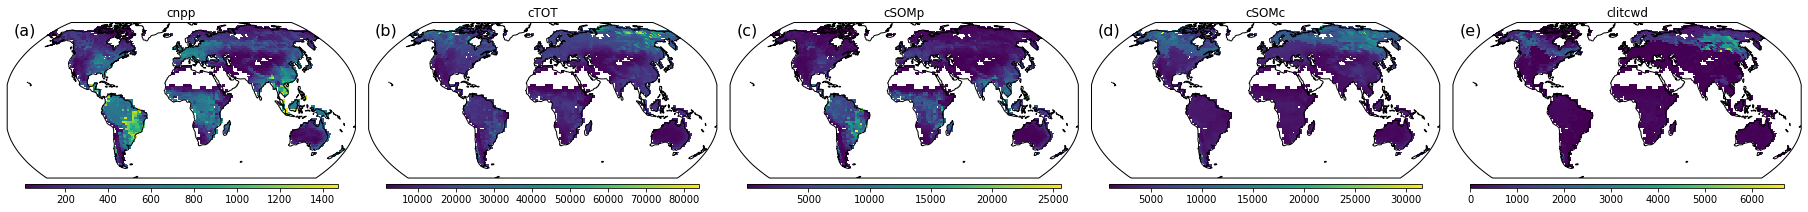

In [5]:
if model == 'mim':
    Cvars =['cnpp','cTOT','cSOMp','cSOMc','clitcwd']
else:
    Cvars =['cnpp','cTOT','clitcwd']

globalSum(ds,Cvars, plot=True)

# Now call the map_function
fig, axes = plt.subplots(nrows=1, ncols=len(Cvars), figsize=((5*len(Cvars)),6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = ds[Cvars[index[0]]].isel(time=-1)
    map_function(da, panel=panel[i], ax=ax, title=Cvars[index[0]], cb=2)

### Look at changes in soil pools in last 100 years

change cTOT = 0.0 Pg C / 100.0 years 


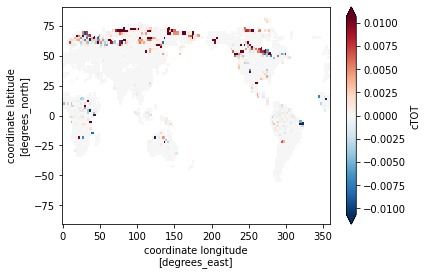

In [6]:
d_ds = (ds.isel(time=-1) - ds.isel(time=-2)) / (ds.time.isel(time=-1) - ds.time.isel(time=-2) )
f_ds = d_ds/ds.isel(time=-1)*100
d_ds['cTOT'].plot(robust=True);

#ds['cTOT'].isel(time=-1).plot(robust=True)

temp = d_ds['cTOT'] * area 
temp = temp.sum(dim=('lat','lon')) * 1e-15
dtime = (ds.time.isel(time=-1) - ds.time.isel(time=-2))
         
print('change cTOT = '+str(np.round(temp.values,3))+' Pg C / '+str(dtime.values)+' years ')

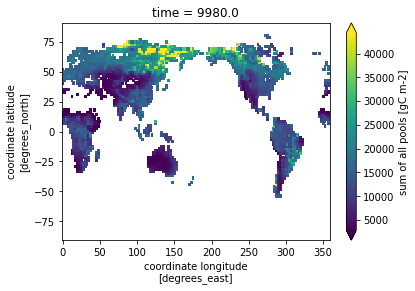

In [7]:
ds['cTOT'].isel(time=-1).plot(robust=True);

------------------
## Quick look at latest state of model

cnTOT
   mean= 11.1 min= 6.1 max= 17.7
cnMIC
   mean= 7.1 min= 5.2 max= 10.1
relMIC
   mean= 0.9 min= 0.1 max= 4.1


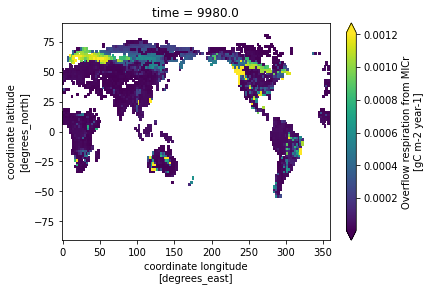

In [8]:
meanVars = ['cnTOT','cnMIC', 'relMIC']
for i in range(len(meanVars)):
    print(meanVars[i]) 
    print('   mean= '+str(np.round(ds[meanVars[i]].mean().values,1))+
          ' min= '+str(np.round(ds[meanVars[i]].min().values,1))+
          ' max= '+str(np.round(ds[meanVars[i]].max().values,1)))
ds.cOverflow_r.isel(time=-1).plot(robust=True);

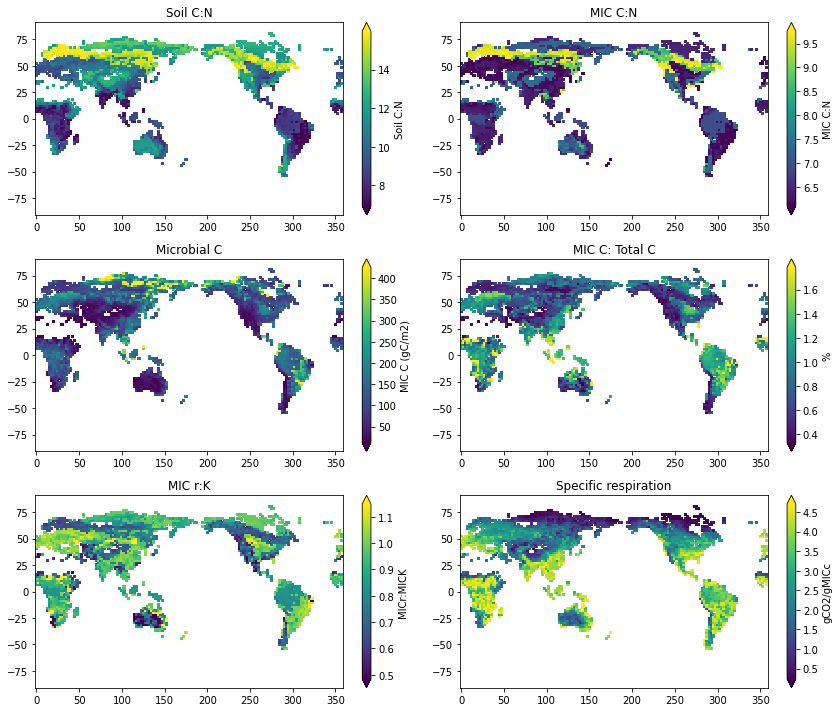

In [9]:
ncols = 2
nrows = 3
#  lists of variables, titles & labels
plotVars = ['cnTOT','cnMIC','cMICtot','relMIC','MICrK','specRESP']
plotTitle = ['Soil C:N','MIC C:N','Microbial C','MIC C: Total C','MIC r:K','Specific respiration']
plotLable = 'Soil C:N','MIC C:N','MIC C (gC/m2)','%','MICr:MICK', 'gCO2/gMICc'

# create the plots
fig = plt.figure(figsize=(12,10))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c) for r in range(0, nrows) for c in range(0, ncols) ]

# add some data
i = 0
for ax in axes:
    ds[plotVars[i]].isel(time=-1).plot(ax=ax, robust=True, cbar_kwargs={'label': plotLable[i]})
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(plotTitle[i])
    i = i+1

plt.tight_layout()

# Read observations:
- Microbial C:N, Xu et al. 2013  https://doi-org.cuucar.idm.oclc.org/10.1111/geb.12029, avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- HR Hashimoto et al Biogeosciences 12: 4121-4132. doi:10.5194/bg-12-4121-2015, downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


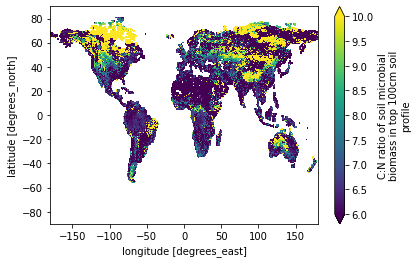

In [10]:
obsIn = "/project/tss/wwieder/soilCN/global_run/"

xuMic = obsIn+'GLOBAL_MICROBIAL_BIOMASS_C_N_P_1264/data/Global_Soil_Microbial_BiomassCN.nc'
dsXu = xr.open_mfdataset(xuMic, decode_times=True,combine='by_coords')
dsXu.CN100cm.plot(vmax=10,vmin=6);

GSDE = obsIn+'GSDE/'
GSDEoc = xr.open_mfdataset(GSDE+'OC5min.nc', decode_times=True,combine='by_coords')
GSDEtn = xr.open_mfdataset(GSDE+'TN5min.nc', decode_times=True,combine='by_coords')
GSDEoc['CN'] = GSDEoc.OC / GSDEtn.TN.where(GSDEtn.TN>0)
GSDEoc['CNmean'] = GSDEoc.CN.where(GSDEoc.depth<=100).mean(dim='depth')

HWSD = obsIn+'input_data/Soil_obs.nc'
dsOBS = xr.open_mfdataset(HWSD, decode_times=True,combine='by_coords')

NCSCD = obsIn+'input_data/NCSCD_Circumarctic_100cmSOCC_025deg.nc'
dsNCSCD = xr.open_mfdataset(NCSCD, decode_times=True,combine='by_coords')

dsHR = xr.open_mfdataset((obsIn+'RH_yr_Hashimoto2015.nc'), decode_times=False,combine='by_coords' )

dsOBS['HWSD_SOCall'] = dsOBS.HWSD_SOC.sum(dim='nlevsoi').where(dsOBS.HWSD_SOC.isel(nlevsoi=0)>0)
dsOBS['HWSD_SOCall'].attrs = dsOBS.HWSD_SOC.attrs
zon_meanOBS = dsOBS.mean(dim='lon') * 1000 #gC/m2

## Regrid observations

In [11]:
dsXu_out = xr.Dataset({'lat': (['lat'], ds.lat),
                     'lon': (['lon'], ds.lon)})
GSDEoc_out = dsXu_out

In [12]:
# NOTE: [from xesmf], Data arrays should have (lat, lon) on the right. 
# If not, use DataArray.transpose or numpy.transpose to preprocess the data.
# Note this is also a pretty quick and dirty job, not sure how coastlines are bing handled?

XuRegridder = xe.Regridder(dsXu, dsXu_out, 'bilinear',periodic=True, reuse_weights=True)
GSDEregridder = xe.Regridder(GSDEoc, GSDEoc_out, 'bilinear',periodic=True, reuse_weights=True)
XuRegridder  # print basic regridder information.

Reuse existing file: bilinear_360x720_96x144_peri.nc
Reuse existing file: bilinear_1680x4320_96x144_peri.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x720_96x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (360, 720) 
Output grid shape:          (96, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

using dimensions ('lat', 'lon') from data variable BIOME as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable OC as the horizontal dimensions for this dataset.


/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (depth: 8, lat: 96, lon: 144)
Coordinates:
  * depth    (depth) float32 4.5 9.1 16.6 28.9 49.3 82.9 138.3 229.6
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
    time     float64 9.98e+03
Data variables:
    OC       (depth, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    CN       (depth, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    CNmean   (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    regrid_method:  bilinear


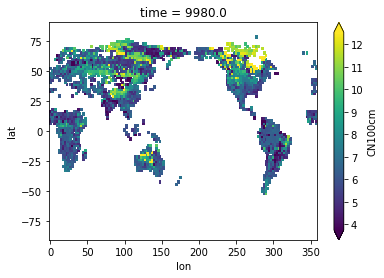

In [13]:
dsXu_out = XuRegridder(dsXu)
GSDEoc_out = GSDEregridder(GSDEoc)

dsXu_out = dsXu_out.where(ds.cnpp.isel(time=-1)>10)
GSDEoc_out = GSDEoc_out.where(ds.cnpp.isel(time=-1)>10)
dsXu_out.CN100cm.plot(robust=True);
print(GSDEoc_out)

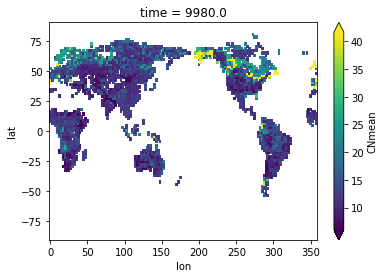

In [14]:
GSDEoc_out['CNmean'].plot(robust=True);

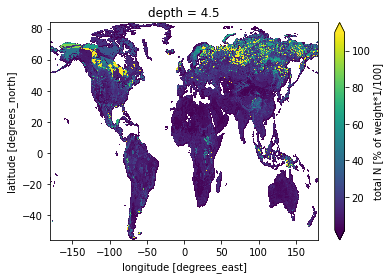

In [15]:
GSDEtn['TN'].isel(depth=0).plot(robust=True);

### unweighted zonal means

In [16]:
minNPP = 10
zon_meanCNmim = ds.where(ds.cnpp>minNPP).mean(dim='lon') 

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


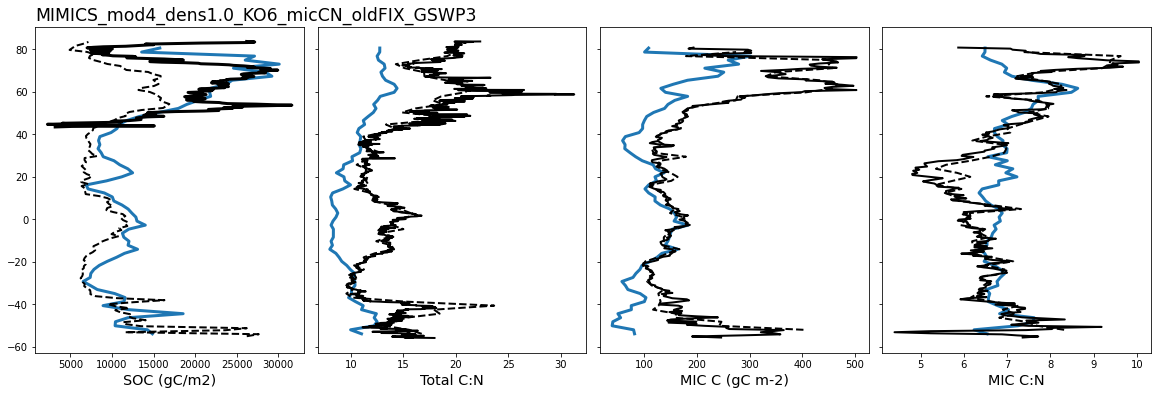

In [17]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, sharey=True, figsize=[20,6])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)
color = ['tab:blue','tab:orange'] # for MIM, CAS
linestyle= ['-', '--']            # for CN,  Conly

# SOC
labels = ['MIMICS-CN','HWSD','NCSCD']
ax1.plot(zon_meanCNmim.get('cTOT').isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax1.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
ax1.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e2), dsNCSCD.lat,lw=3, color='k') #convert kgC to gC/m2
ax1.set_xlabel('SOC (gC/m2)', fontsize='x-large')
#ax1.legend(labels=labels, frameon = False, fontsize='medium',loc=4)
ax1.set_title(sim,loc='left', fontsize='xx-large')

# Soil C:N
v3 ='cnTOT' #'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax2.plot(zon_meanCNmim.get(v3).isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax2.plot(GSDEoc['CNmean'].mean(dim='lon'), GSDEoc.lat,lw=2, color='k')
ax2.plot(GSDEoc_out['CNmean'].mean(dim='lon'), GSDEoc_out.lat,lw=2, color='k',linestyle='--')
ax2.set_xlabel('Total C:N', fontsize='x-large');
labels = ['MIMICScn','Shangguan et al. 2014', 'GSDE regrid']
#ax3.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

# MIC tot
v4 = 'cMICtot' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax3.plot(zon_meanCNmim.get(v4).isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax3.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax3.plot(dsXu_out.SMC100cm.mean(dim='lon'), dsXu_out.lat,lw=2, color='k',linestyle='--')
ax3.set_xlabel('MIC C ('+ds.get(v4).attrs['units']+')', fontsize='x-large');
labels = ['MIMICS-CN','Xu et al. 2013','Xu regrid']
#ax2.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

# MICcn
v5 = 'cnMIC' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax4.plot(zon_meanCNmim.get(v5).isel(time=-1), zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
ax4.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax4.plot(dsXu_out.CN100cm.mean(dim='lon'), dsXu_out.lat,lw=2, color='k',linestyle='--')
labels = ['MIMICS-CN','Xu et al. 2013','Xu regrid']
ax4.set_xlabel('MIC C:N', fontsize='x-large');


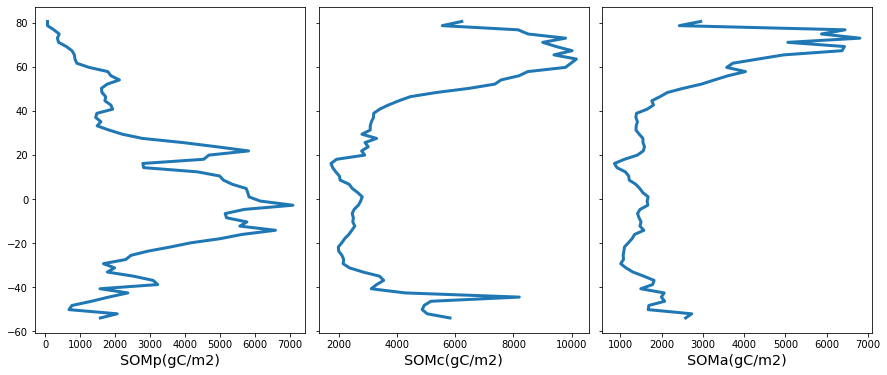

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize=[15,6])
fig.subplots_adjust(hspace=0, wspace=0.05)

ax1.plot(zon_meanCNmim.get('cSOMp').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax1.set_xlabel('SOMp(gC/m2)', fontsize='x-large');

ax2.plot(zon_meanCNmim.get('cSOMc').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax2.set_xlabel('SOMc(gC/m2)', fontsize='x-large');

ax3.plot(zon_meanCNmim.get('cSOMa').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax3.set_xlabel('SOMa(gC/m2)', fontsize='x-large');

### Correlation between soil stoichoimetry and microbial compostion or microbial C:N
_sensu_ Fierer et al 2009 (Ecology Letters) likely need newer refs.

In [19]:
################### Function to truncate color map ###################
def truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100):
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))

    arr = np.linspace(0, 50, 100).reshape((10, 10))
    return new_cmap

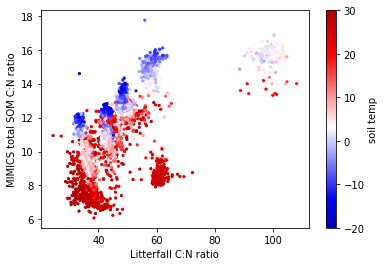

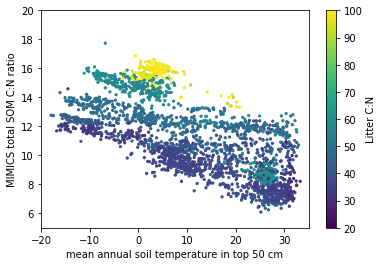

In [20]:
ds_1 = ds.isel(time=-1)
ds_1['cnLIT'] = (ds_1.cLitInput_metb + ds_1.cLitInput_struc) / (ds_1.nLitInput_metb + ds_1.nLitInput_struc)
ds_1['cnLIT'].attrs['long_name'] = 'C:N litter inputs'

color_by = ds_1.tsoilC
label = 'soil temp'  # Need to rename if 'color_by' is changed

fig, ax = plt.subplots()
s = ax.scatter(ds_1['cnLIT'], ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               cmap = truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = -20,            # Min value
               vmax = 30)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds['cnLIT'].attrs['long_name'])
plt.ylabel(ds['cnTOT'].attrs['long_name'])
#ax.set_xlim(20, 110)
plt.show();

color_by = ds_1['cnLIT'] 
label = 'Litter C:N'     
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), constrained_layout=True)
fig, ax = plt.subplots()
s = ax.scatter(ds_1.tsoilC, ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               #cmap = truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = 20,            # Min value
               vmax = 100)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds['tsoilC'].attrs['long_name'])
plt.ylabel(ds['cnTOT'].attrs['long_name'])
ax.set_xlim(-20, 35)
ax.set_ylim(5, 20)
plt.show();


**Figure X** Litter quality and temperature interact to control soil C:N. 

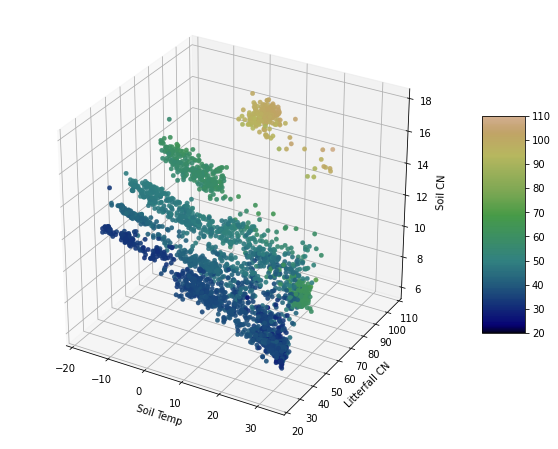

In [21]:
# try above in 3d space
from mpl_toolkits.mplot3d import Axes3D

y = ds_1['cnLIT'].values.ravel()
x = ds_1['tsoilC'].values.ravel()
z = ds_1['cnTOT'].values.ravel()
fig = plt.figure(figsize=[10,8])
ax = fig.gca(projection='3d')

surf = ax.scatter(x, y, z, linewidth=0.3, antialiased=True, 
                  c = y, marker='o', alpha=0.9,
                  cmap = truncate_colormap(cmapIn='gist_earth', minval=.0, maxval=.85),
                  vmin = 20, vmax = 110)          

ax.set_ylim(20, 110)
#ax.set_zlim(8, 15)
ax.set_ylabel('Litterfall CN')
ax.set_xlabel('Soil Temp')
ax.set_zlabel('Soil CN');
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.set_label('Litterfall CN')
plt.show()

---------------------
# Look at MIMCS_Conly w/ GSWP3 & CRU + CASAcn
- `MIMICS_mod4_GSWP3`,  leaching as fraction of total DIN pool
- `MIMICS_mod4_dens1.0_GSWP3`, density dependent exponent = 1
- `MIMICS_mod4_dens1.0_KO6_GSWP3`, KO = 6, turnover * desorbtion as in `MIMICS_desorb2`
- `MIMICS_mod4_dens1.0_KO6_Conly`, C-only of above
- `CASACNP_mod4_GSWP3`
- `CASACNP_mod4_Conly`

In [22]:
cruConlyIN = '/project/tss/wwieder/CASACLM/GRID/OUTPUT_GRID_CRU_NCEP/MIMICS_SPIN_b/'
CcasCRU = cruConlyIN+'casaclm_pool_flux_9000_9980.nc'
CmimCRU = cruConlyIN+'mimics_pool_flux_9000_9980.nc'
print('CmimCRU = ' +CmimCRU)

simMIMc = 'MIMICS_mod4_dens1.0_KO6_Conly'
caseMIMc = 'GRID_CN/'+simMIMc+'/OUTPUT_C/SPIN/'
Ccas = path+caseMIMc+'casaclm_pool_flux_*80.nc' 
Cmim = path+caseMIMc+'mimics_pool_flux_*80.nc' 
print('Cmim = '+Cmim)

simCASc  = 'CASACNP_mod4_Conly' 
caseCASc = 'GRID_CN/'+simCASc+'/OUTPUT_C/SPIN2/'
full_pathCASc = path+caseCASc+'casaclm_pool_flux_*80.nc' # casa files for vegetation results
print('Ccas = '+full_pathCASc)

simCAScn  = 'CASACNP_mod4_GSWP3' 
caseCAScn = 'GRID_CN/'+simCAScn+'/OUTPUT_CN/SPIN2/'
full_pathCAScn = path+caseCAScn+'casaclm_pool_flux_*80.nc' # casa files for vegetation results
print('CNcas = '+full_pathCAScn)

CmimCRU = /project/tss/wwieder/CASACLM/GRID/OUTPUT_GRID_CRU_NCEP/MIMICS_SPIN_b/mimics_pool_flux_9000_9980.nc
Cmim = /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod4_dens1.0_KO6_Conly/OUTPUT_C/SPIN/mimics_pool_flux_*80.nc
Ccas = /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/CASACNP_mod4_Conly/OUTPUT_C/SPIN2/casaclm_pool_flux_*80.nc
CNcas = /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/CASACNP_mod4_GSWP3/OUTPUT_CN/SPIN2/casaclm_pool_flux_*80.nc


### Open each dataset

In [23]:
# MIMICS, C-only, CRU-NCEP
dsCmimCRU   = xr.open_mfdataset(CmimCRU, decode_times=True,combine='by_coords') 
dsCvegCRU   = xr.open_mfdataset(CcasCRU, decode_times=True,combine='by_coords')
dsCmimCRU['cnpp'] = dsCvegCRU['cnpp'] # copy plant productivity to mimics files
dsCmimCRU['cgpp'] = dsCvegCRU['cgpp']

# MIMICS, C-only, GSWP3
dsCveg   = xr.open_mfdataset(Ccas,  decode_times=True, combine='by_coords') 
dsCmim   = xr.open_mfdataset(Cmim,  decode_times=True, combine='by_coords') 
dsCmim['cnpp'] = dsCveg['cnpp'] # copy plant productivity to mimics files
dsCmim['cgpp'] = dsCveg['cgpp']

# CASA C-only & CN, GSPW3
dsCcas    = xr.open_mfdataset(full_pathCASc,  decode_times=True, combine='by_coords')
dsCNcas   = xr.open_mfdataset(full_pathCAScn, decode_times=True, combine='by_coords')
print (' -- data read in -- ')

 -- data read in -- 


#### Sum pools & print mean

In [24]:
print(minNPP)
dsCmimCRU = dsCmimCRU.where(dsCmimCRU.cnpp>minNPP)
dsCmim = dsCmim.where(dsCmim.cnpp>minNPP)
dsCcas = dsCcas.where(dsCcas.cnpp>minNPP)
dsCNcas = dsCNcas.where(dsCNcas.cnpp>minNPP)

dsCmimCRU = utils.sum_pools(dsCmimCRU, mod='mim', CN='False')
dsCmim  = utils.sum_pools(dsCmim, mod='mim', CN='False')
dsCcas  = utils.sum_pools(dsCcas,  mod='cas', CN='False')
dsCNcas = utils.sum_pools(dsCNcas, mod='cas', CN='True' )

10


In [25]:
Cvars =['cgpp','cnpp','cTOT']
# MIMICS_Conly results, GSWP3
print('')
print('MIMICS_C only GSWP3')
globalSum(dsCmim,Cvars, plot=False)

# MIMICS_CN results
print('')
print(sim+' CN results')
globalSum(ds,Cvars, plot=False)

# CASA_C results
print('')
print('CASA-C, GSWP3 results')
globalSum(dsCcas,Cvars, plot=False)

# CASA_CN results
print('')
print('CASA-CN, GSWP3 results')
globalSum(dsCNcas,Cvars, plot=False)

# MIMICS_C, CRUNCEP
print('')
print('MIMICS_C only CRUNCEP')
globalSum(dsCmimCRU,Cvars, plot=False)


MIMICS_C only GSWP3
global cgpp 108.3 Pg C
global cnpp 43.5 Pg C
global cTOT 1527.9 Pg C

MIMICS_mod4_dens1.0_KO6_micCN_oldFIX_GSWP3 CN results
global cgpp 108.3 Pg C
global cnpp 39.1 Pg C
global cTOT 1442.6 Pg C

CASA-C, GSWP3 results
global cgpp 108.3 Pg C
global cnpp 43.5 Pg C
global cTOT 994.4 Pg C

CASA-CN, GSWP3 results
global cgpp 108.3 Pg C
global cnpp 40.4 Pg C
global cTOT 882.7 Pg C

MIMICS_C only CRUNCEP
global cgpp 117.8 Pg C
global cnpp 48.8 Pg C
global cTOT 1424.2 Pg C


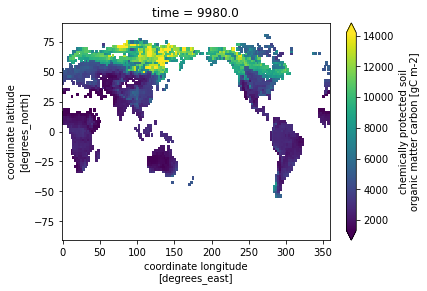

In [26]:
dsCmim.isel(time=-1).cSOMc.plot(robust=True);

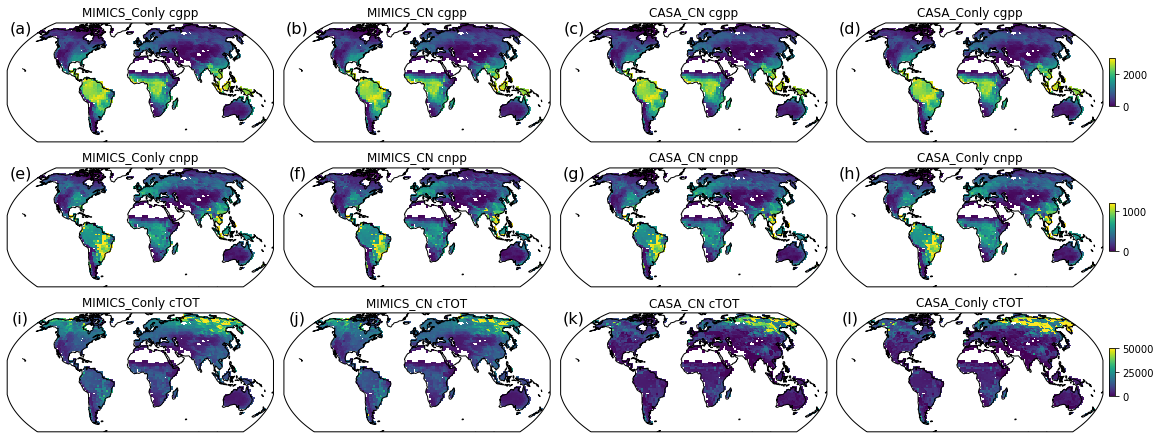

In [27]:
# Call the map_function
sims = ['MIMICS_Conly ',('MIMICS_CN '),('CASA_CN '), ('CASA_Conly ')]
Cvars =['cgpp','cnpp','cTOT']
vmax = [3000  ,1200  ,5e4]  #max values for each variable

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    i = index[0]
    j = index[1]
    k = k+1
    if j == 0: da = dsCmim[Cvars[i]].isel(time=-1)
    if j == 1: da = ds[Cvars[i]].isel(time=-1)
    if j == 2: da = dsCNcas[Cvars[i]].isel(time=-1)
    if j == 3: da = dsCcas[Cvars[i]].isel(time=-1)

    if j < 3: map_function(da, panel=panel[k], ax=ax, vmax=vmax[i], vmin=0, cb=0, title=sims[j]+Cvars[i])
    else: map_function(da, panel=panel[k], ax=ax, vmax=vmax[i], vmin=0, cb=1, title=sims[j]+Cvars[i])

## Difference in NPP (CN-C)
- most notably in boreal forests.
- somewhat int tropcs

### Call the map_function for: 
- MIMICScn - MIMICS_Conly
- CASAcn - CASA_Conly
- MIMICS_cn - CASA_cn

In [43]:
inVars  = ['cnpp','cTOT','cSOMp', 'cSOMc']
newVars = ['d_cnpp','d_cTOT','d_cSOMp', 'd_cSOMc']
ds2 = ds.copy(deep=True)
for i in range(len(inVars)):
    # MIMICS-C GSWP3 - MIMICS-C CRUNCEP
    dsCmim[newVars[i]] = (dsCmim[inVars[i]].isel(time=-1) - dsCmimCRU[inVars[i]].isel(time=-1))
    dsCmim[newVars[i]].attrs['long_name'] = 'MIMICS C GSWP3 '+inVars[i]+' difference from CRUNCEP'

    # MIMICS-CN -  MIMICS-Conly GSWP3
    ds[newVars[i]] = (ds[inVars[i]].isel(time=-1) - dsCmim[inVars[i]].isel(time=-1))
    ds[newVars[i]].attrs['long_name'] = 'MIMICScn - MIMICS Conly'

    if (i<2):
        # CASA-CN - CASA-Conly GSWP3
        dsCNcas[newVars[i]] = (dsCNcas[inVars[i]].isel(time=-1) - dsCcas[inVars[i]].isel(time=-1))
        dsCNcas[newVars[i]].attrs['long_name'] = 'CASAcn - CASA Conly'
        
        # MIMICS-CN - CASA-CN GSWP3
        ds2[newVars[i]] = (ds2[inVars[i]].isel(time=-1) - dsCNcas[inVars[i]].isel(time=-1))
        ds2[newVars[i]].attrs['long_name'] = 'MMIMICScn - CASAcn'
        

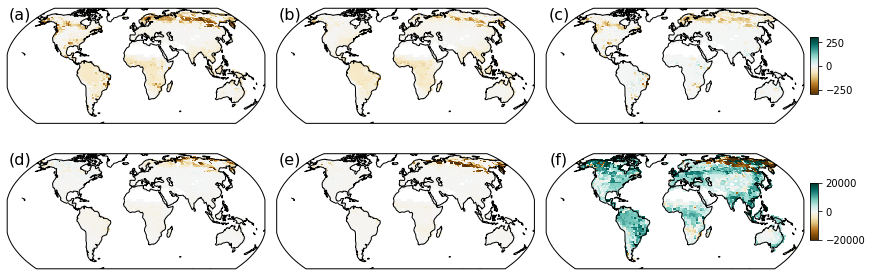

In [44]:
Cvars = ['d_cnpp','d_cTOT']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    #print(index)
    i = index[0]
    j = index[1]
    k = k+1
    cb=0
    #if i == 0 : da = dsCmim[Cvars[j]]
    if j == 0 : da = ds[Cvars[i]]
    if j == 1 : da = dsCNcas[Cvars[i]]
    if j == 2 : 
        da = ds2[Cvars[i]]
        cb=1 #turn on CB for right most colum
        
    if i==0:
        #map_function(da, panel=panel[k], ax=ax, title=da.attrs['long_name'], cb=1,cmap='BrBG', vmax=75, vmin=-75) # for % change
        map_function(da, panel=panel[k], ax=ax, title=None, cb=cb,cmap='BrBG', vmax=300, vmin=-300) # for absolute change
    else:
        map_function(da, panel=panel[k], ax=ax, title=None, cb=cb,cmap='BrBG', vmax=2e4, vmin=-2e4)
    

**Fig X** Differences in NPP and total soil C (top and bottom rows, respectively). MIMICScn shows greater N limitatation, shown by lower NPP (a) and lower soil C pools (d), relative to its C-only version. CASAcn shows similar spatial patterns, with lower NPP and soil C stocks than the C-only version of CASA (b,e).  MIMICScn also shows greater N limitation at high latidues than CASAcn (c), but larger global soil C stocks (f).

## Look at zonal mean plots for lat. bands

In [34]:
var  =  ['cnpp', 'cgpp','cTOT']
varLong  =  ['npp', 'gpp','total soil C']

# weight values by grid cell
ann_fluxCNmim = ds * ds.landarea *1e6
ann_fluxCNcas = dsCNcas * dsCNcas.landarea *1e6
ann_fluxCcas  = dsCcas * dsCcas.landarea *1e6
ann_fluxCmim  = dsCmim * dsCmim.landarea *1e6
ann_fluxCmimCRU = dsCmimCRU * dsCmimCRU.landarea *1e6
for i in range(len(var)):
    ann_fluxCNmim.get(var[i]).attrs['units'] = 'gC y-1'
    ann_fluxCNcas.get(var[i]).attrs['units'] = 'gC y-1'
    ann_fluxCcas.get(var[i]).attrs['units'] = 'gC y-1'
    ann_fluxCmim.get(var[i]).attrs['units'] = 'gC y-1'    
    ann_fluxCmimCRU.get(var[i]).attrs['units'] = 'gC y-1'

In [35]:
zon_sumCNmim = ann_fluxCNmim.sum(dim='lon') *1e-15
zon_sumCNcas = ann_fluxCNcas.sum(dim='lon') *1e-15
zon_sumCcas = ann_fluxCcas.sum(dim='lon') *1e-15
zon_sumCmim = ann_fluxCmim.sum(dim='lon') *1e-15
zon_sumCmimCRU = ann_fluxCmimCRU.sum(dim='lon') *1e-15
# unweighted zonal means
minGPP = 10
zon_meanCNmim = ds.where(ds.cgpp>minGPP).mean(dim='lon') 
zon_meanCNcas = dsCNcas.where(ds.cgpp>minGPP).mean(dim='lon') 
zon_meanCcas = dsCcas.where(ds.cgpp>minGPP).mean(dim='lon') 
zon_meanCmim = dsCmim.where(ds.cgpp>minGPP).mean(dim='lon') 
zon_meanCmimCRU = dsCmimCRU.where(dsCmimCRU.cgpp>minGPP).mean(dim='lon') 

# Read observations:
- Microbial C:N, Xu et al. 2013  https://doi-org.cuucar.idm.oclc.org/10.1111/geb.12029, avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- HR Hashimoto et al Biogeosciences 12: 4121-4132. doi:10.5194/bg-12-4121-2015, downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Text(0.5, 0, 'MIMICS microbial C:N ratio')

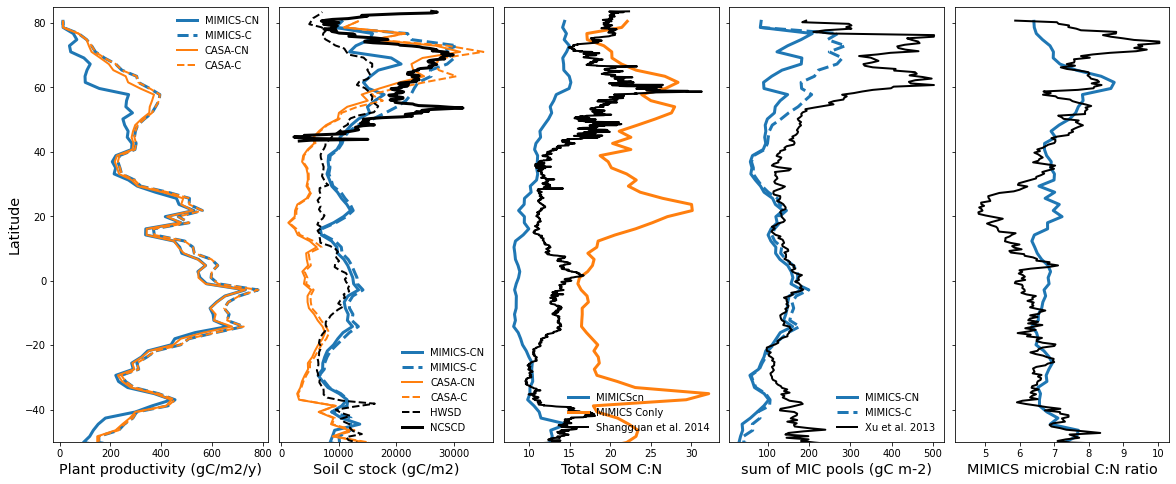

In [36]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=[20,8])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)
color = ['tab:blue','tab:orange'] # for MIM, CAS
linestyle= ['-', '--']            # for CN,  Conly

# NPP
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C']
ax1.plot(zon_meanCNmim.get('cnpp').isel(time=-1), zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
ax1.plot(zon_meanCmim.get('cnpp').isel(time=-1),  zon_meanCmim.lat,  lw=3,color=color[0],linestyle=linestyle[1])
ax1.plot(zon_meanCNcas.get('cnpp').isel(time=-1), zon_meanCNcas.lat, lw=2,color=color[1],linestyle=linestyle[0])
ax1.plot(zon_meanCcas.get('cnpp').isel(time=-1), zon_meanCcas.lat, lw=2,color=color[1],linestyle=linestyle[1])
ax1.set_xlabel('Plant productivity (gC/m2/y)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.set_ylim(-50, 85)
ax1.legend(labels=labels, frameon = False, fontsize='medium',loc=1)

# SOC
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C','HWSD','NCSCD']
ax2.plot(zon_meanCNmim.get('cTOT').isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax2.plot(zon_meanCmim.get('cTOT').isel(time=-1),  zon_meanCmim.lat, lw=3,color=color[0],linestyle=linestyle[1])
ax2.plot(zon_meanCNcas.get('cTOT').isel(time=-1), zon_meanCNcas.lat,lw=2,color=color[1],linestyle=linestyle[0])
ax2.plot(zon_meanCcas.get('cTOT').isel(time=-1), zon_meanCcas.lat,  lw=2,color=color[1],linestyle=linestyle[1])
ax2.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
ax2.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e2), dsNCSCD.lat,lw=3, color='k') #convert kgC to gC/m2
ax2.set_xlabel('Soil C stock (gC/m2)', fontsize='x-large')
ax2.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

# Soil C:N
v3 ='cnTOT' #'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax3.plot(zon_meanCNmim.get(v3).isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax3.plot(zon_meanCNcas.get(v3).isel(time=-1), zon_meanCmim.lat,lw=3,color=color[1],linestyle=linestyle[0])
ax3.plot(GSDEoc['CNmean'].mean(dim='lon'), GSDEoc.lat,lw=2, color='k')
ax3.set_xlabel('Total SOM C:N', fontsize='x-large');
labels = ['MIMICScn','MIMICS Conly','Shangguan et al. 2014']
ax3.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

'''
ax3.plot(zon_meanCNmim.get('cSOMp').isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax3.plot(zon_meanCmim.get('cSOMp').isel(time=-1),  zon_meanCmim.lat, lw=3,color=color[0],linestyle=linestyle[1])
ax3.set_xlabel('SOMp(gC/m2)', fontsize='x-large');

ax4.plot(zon_meanCNmim.get('cSOMc').isel(time=-1), zon_sumCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
ax4.plot(zon_meanCmim.get('cSOMc').isel(time=-1),  zon_meanCmim.lat, lw=3,color=color[0],linestyle=linestyle[1])
#ax4.plot(zon_sumCNcas.get('csoilslow').isel(time=-1), zon_meanCNcas.lat, lw=3)
ax4.set_xlabel('SOMc(gC/m2)', fontsize='x-large');
'''

v4 = 'cMICtot' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax4.plot(zon_meanCNmim.get(v4).isel(time=-1), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax4.plot(zon_meanCmim.get(v4).isel(time=-1), zon_meanCmim.lat,lw=3,color=color[0],linestyle=linestyle[1])
ax4.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax4.set_xlabel(ds.get(v4).attrs['long_name']+' ('+ds.get(v4).attrs['units']+')', fontsize='x-large');
labels = ['MIMICS-CN','MIMICS-C','Xu et al. 2013']
ax4.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

v5 = 'cnMIC' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax5.plot(zon_meanCNmim.get(v5).isel(time=-1), zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
#ax5.plot(zon_meanCNcas.get(v5).isel(time=-1), zon_meanCmim.lat,  lw=3,color=color[1],linestyle=linestyle[0])
ax5.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax5.set_xlabel(ds.get(v5).attrs['long_name'], fontsize='x-large')
#               +' ('+ds.get(v5).attrs['units']+')', fontsize='x-large');


In [ ]:
ax3.plot(zon_meanCNmim.get('cSOMp').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax3.plot(zon_meanCmim.get('cSOMp').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax3.plot(zon_meanCmimCRU.get('cSOMp').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
ax3.set_xlabel('SOMp(gC/m2)', fontsize='x-large');

ax4.plot(zon_meanCNmim.get('cSOMc').isel(time=-1), zon_sumCNmim.lat, lw=3)
ax4.plot(zon_meanCmim.get('cSOMc').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax4.plot(zon_meanCmimCRU.get('cSOMc').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
#ax4.plot(zon_sumCNcas.get('csoilslow').isel(time=-1), zon_meanCNcas.lat, lw=3
ax4.set_xlabel('SOMc(gC/m2)', fontsize='x-large');

ax5.plot(zon_meanCNmim.get('cSOMa').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax5.plot(zon_meanCmim.get('cSOMa').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax5.plot(zon_meanCmimCRU.get('cSOMa').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
#ax5.plot(zon_sumCNcas.get('csoilmic').isel(time=-1), zon_meanCNcas.lat, lw=3
ax5.set_xlabel('SOMa(gC/m2)', fontsize='x-large');

#### NPP
- N limitation reduces NPP in all  models, expecially MIMICS
- CRUNCEP has higher mid & high latitude NPP than GSWP3 forcing

### Total SOM
- lower with CN models, especially in  boreal forest & arctic,  where NPP is lower
- most of MIMICS decreases are in SOMc

### SOM pools
- large drop in SOMc with MIMICScn
- also increases in microbial biomass (fraction of total SOM)
- modify microbial kinnetics of SOMc to increase  SOMc & decrease MIC

In [ ]:
Cvars = ['nMineral','cnpp','cTOT']
max0= [10,1200,5e4]
min0=[0,0,0]
max1=[3,200,2e4]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    #print(index)
    i = index[0]
    j = index[1]
    k = k+1
    ## COuld add MIMcn - MIMc, but not sure it's warranted...
    '''if j==0:
        if i !=0:
            da = ds[Cvars[i]].isel(time=-1) - dsCmim[Cvars[i]].isel(time=-1)        
            map_function(da, panel=panel[k], ax=ax, title='MIMICScn - Conly '+Cvars[i], cb=1, cmap='BrBG',vmax=max1[i], vmin=-max1[i]);'''
    if j==0: 
        da = ds[Cvars[i]].isel(time=-1)
        map_function(da, panel=panel[k], ax=ax, title='MIMICS-CN '+da.attrs['long_name'], cb=1,vmax=max0[i], vmin=0) 
    if j==1:
        da = ds[Cvars[i]].isel(time=-1) - dsCNcas[Cvars[i]].isel(time=-1)        
        map_function(da, panel=panel[k], ax=ax, title='MIMICS - CASA '+Cvars[i], cb=1, cmap='BrBG',vmax=max1[i], vmin=-max1[i]);

In [ ]:
zon_meanCNmim